# VLB Startup Shear

**Vernerey-Long-Brighenti (VLB) transient network model — Startup transients**

## Context: VLB Transient Networks

The VLB framework models polymers with reversible cross-links via a **distribution tensor** $\boldsymbol{\mu}$ tracking the second moment of the chain end-to-end vector distribution. For startup shear at constant $\dot{\gamma}$:

$$\sigma_{12}(t) = \frac{G_0 \dot{\gamma}}{k_d}\left(1 - e^{-k_d t}\right) = \eta_0 \dot{\gamma} \left(1 - e^{-t/t_R}\right)$$

Key physics: chains stretch affinely with flow ($\mathbf{L} \cdot \boldsymbol{\mu}$) while detaching/reattaching at rate $k_d$ ($k_d(\mathbf{I} - \boldsymbol{\mu})$). Stress builds exponentially with time constant $t_R = 1/k_d$ until steady state $\sigma^{ss} = G_0 \dot{\gamma}/k_d$ is reached.

**Critical diagnostic:** With constant $k_d$, startup is **monotonic** — no stress overshoot. Overshoot indicates force-dependent breakage (Bell model, Notebook 08) or thixotropic structure (DMT).

> **Handbook:** See [VLB Protocols](../../docs/source/models/vlb/vlb_protocols.rst) for complete startup derivation and [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for diagnostic signatures.

## Learning Objectives

- Simulate startup shear at multiple shear rates
- Understand the effect of Weissenberg number on approach to steady state
- Observe monotonic stress growth (no overshoot with constant $k_d$)
- Fit startup data to extract $G_0$ and $k_d$

## Estimated Runtime

- ~1 min (analytical solutions)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
print(f"JAX version: {jax.__version__}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3


## 2. Theory

For startup from equilibrium at constant $\dot{\gamma}$:

$$\sigma_{12}(t) = \frac{G_0 \dot{\gamma}}{k_d}\left(1 - e^{-k_d t}\right) = \eta_0 \dot{\gamma} \left(1 - e^{-t/t_R}\right)$$

$$N_1(t) = \frac{2G_0 \dot{\gamma}^2}{k_d^2}\left(1 - e^{-k_d t}\right) - \frac{2G_0 \dot{\gamma}^2}{k_d} t \, e^{-k_d t}$$

**Key features:**
- σ₁₂ is monotonically increasing (no overshoot)
- Time constant is $t_R = 1/k_d$ regardless of $\dot{\gamma}$
- Steady state: $\sigma^{ss} = G_0 \dot{\gamma}/k_d$
- N₁ can be non-monotonic for Wi = $\dot{\gamma}/k_d$ > 1

In [3]:
# Set model parameters
model = VLBLocal()
model.parameters.set_value("G0", 5000.0)  # Pa
model.parameters.set_value("k_d", 2.0)    # 1/s

print(f"G₀ = {model.G0} Pa")
print(f"k_d = {model.k_d} 1/s")
print(f"t_R = {model.relaxation_time} s")
print(f"η₀ = {model.viscosity} Pa·s")

G₀ = 5000.0 Pa
k_d = 2.0 1/s
t_R = 0.5 s
η₀ = 2500.0 Pa·s


## 3. Startup at Multiple Shear Rates

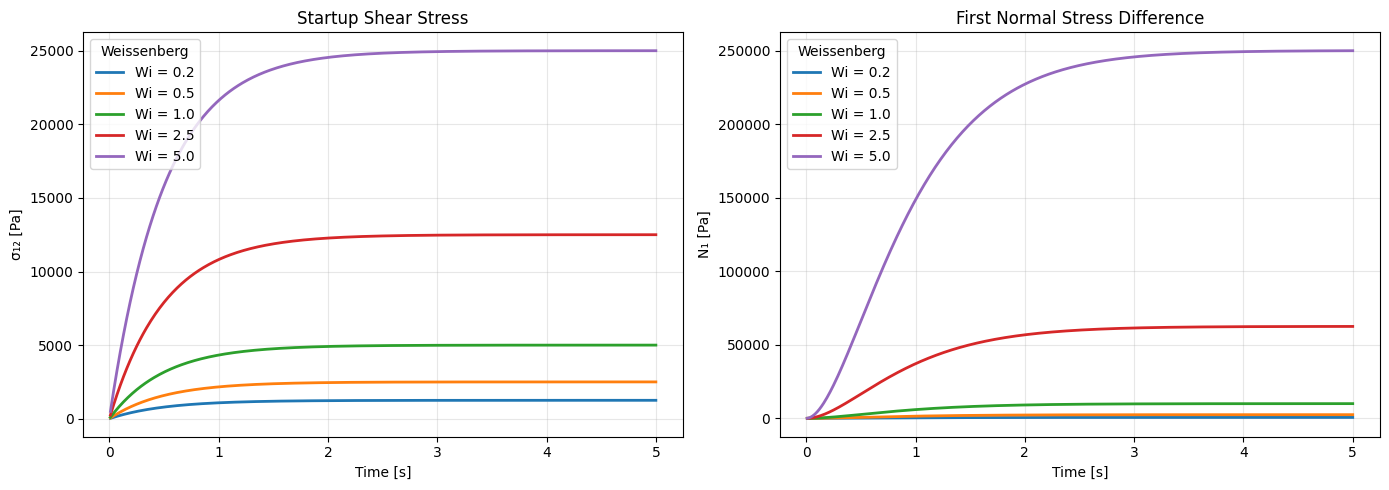

In [4]:
gamma_dots = [0.5, 1.0, 2.0, 5.0, 10.0]  # 1/s
t_end = 5.0  # s (about 10 × t_R)
dt = 0.01
t = np.linspace(dt, t_end, int(t_end / dt))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for gd in gamma_dots:
    Wi = gd / model.k_d
    sigma, N1, strain = model.simulate_startup(t, gamma_dot=gd, return_full=True)
    
    ax1.plot(t, sigma, lw=2, label=f"Wi = {Wi:.1f}")
    ax2.plot(t, N1, lw=2, label=f"Wi = {Wi:.1f}")

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("σ₁₂ [Pa]")
ax1.set_title("Startup Shear Stress")
ax1.legend(title="Weissenberg")
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("N₁ [Pa]")
ax2.set_title("First Normal Stress Difference")
ax2.legend(title="Weissenberg")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Fit Startup Data

Generate noisy synthetic startup data and fit it.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.804795s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0142 | elapsed=0.805s | final_gradient_norm=0.0023


Fit time: 1.09 s
G₀  = 5102.3 Pa (true: 5000)
k_d = 2.0727 1/s (true: 2.0)


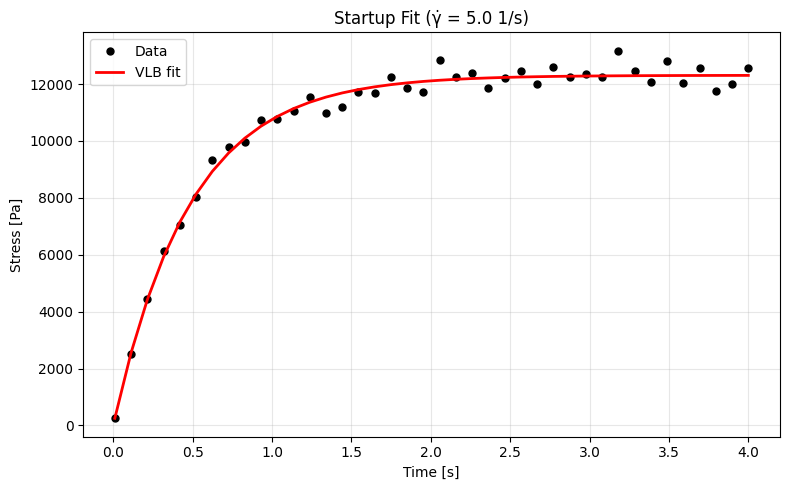

In [5]:
import time as time_mod

# Generate data at γ̇ = 5 /s
np.random.seed(42)
gamma_dot_fit = 5.0
t_data = np.linspace(0.01, 4.0, 40)
sigma_true = (5000.0 * gamma_dot_fit / 2.0) * (1 - np.exp(-2.0 * t_data))
sigma_data = sigma_true * (1 + 0.03 * np.random.randn(len(t_data)))

# Fit
model_fit = VLBLocal()
t0 = time_mod.time()
model_fit.fit(t_data, sigma_data, test_mode="startup", gamma_dot=gamma_dot_fit)
t_elapsed = time_mod.time() - t0

print(f"Fit time: {t_elapsed:.2f} s")
print(f"G₀  = {model_fit.G0:.1f} Pa (true: 5000)")
print(f"k_d = {model_fit.k_d:.4f} 1/s (true: 2.0)")

# Plot
sigma_pred = model_fit.predict(t_data, test_mode="startup", gamma_dot=gamma_dot_fit)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_data, sigma_data, "ko", markersize=5, label="Data")
ax.plot(t_data, np.array(sigma_pred), "r-", lw=2, label="VLB fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"Startup Fit (γ̇ = {gamma_dot_fit} 1/s)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. No Stress Overshoot

A key diagnostic: VLB with constant k_d **cannot** produce stress overshoot. If your material shows overshoot, you need force-dependent k_d (Bell model) or a different framework (DMT, TNT Bell).

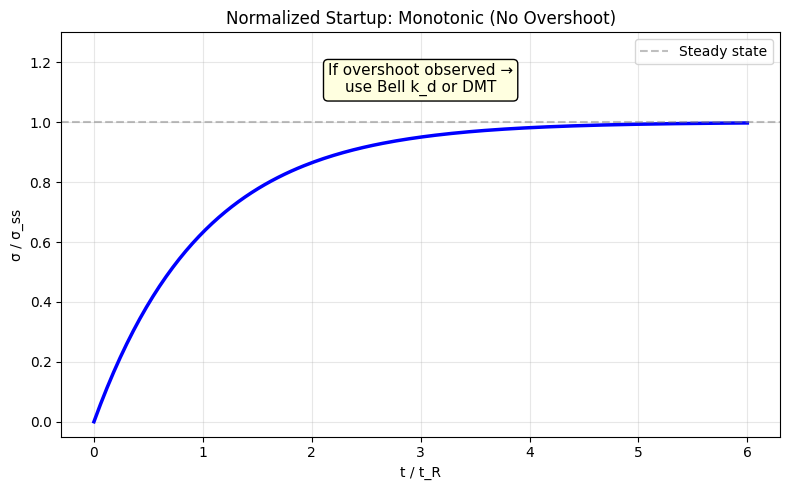

In [6]:
# Verify: normalized stress always approaches 1 from below
fig, ax = plt.subplots(figsize=(8, 5))

t_norm = np.linspace(0, 6, 200)  # in units of t_R
sigma_norm = 1 - np.exp(-t_norm)

ax.plot(t_norm, sigma_norm, "b-", lw=2.5)
ax.axhline(1.0, color="gray", linestyle="--", alpha=0.5, label="Steady state")
ax.set_xlabel("t / t_R")
ax.set_ylabel("σ / σ_ss")
ax.set_title("Normalized Startup: Monotonic (No Overshoot)")
ax.set_ylim(-0.05, 1.3)
ax.legend()
ax.grid(True, alpha=0.3)
ax.annotate("If overshoot observed →\nuse Bell k_d or DMT", 
            xy=(3, 1.1), fontsize=11, ha="center",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

plt.tight_layout()
display(fig)
plt.close(fig)

## Key Takeaways

1. **Startup is exponential** with time constant $t_R = 1/k_d$
2. **No stress overshoot** — monotonic approach to steady state
3. **$N_1$ can be non-monotonic** at high Wi (transient normal stress undershoot)
4. **Steady state matches flow curve** — $\sigma_{ss} = \eta_0 \cdot \dot{\gamma}$

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — distribution tensor evolution, stress formula
- [VLB Protocols](../../docs/source/models/vlb/vlb_protocols.rst) — analytical startup solution derivation
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Next Steps

- **Notebook 03**: Stress relaxation (single exponential)
- **Notebook 05**: SAOS fitting (crossover frequency = $k_d$)
- **Notebook 08**: Bell model with stress overshoot